# Hugging Face Spaces From A Notebook

> A demo of using nbdev with Hugging Face Spaces & Gradio

![Image created with Stable Diffusion from [this space](https://huggingface.co/spaces/stabilityai/stable-diffusion)](blog_cover.jpeg)

[Hugging Face Spaces](https://huggingface.co/spaces/launch) provides an easy ways to deploy a web app with python.  [Gradio](https://gradio.app/) is one of my favorite tools for building these web apps.  Gradio allows you to prototype your web apps in notebooks which allow you to iterate fast.  However, Hugging Face Spaces requires you to package your web application code as a python script named `app.py`.  


However, **thanks to [nbdev](https://nbdev.fast.ai) you can deploy a Gradio app to Spaces from a notebook without having to refactor your code into a script!**,   When you finish this tutorial, you will have an app that looks like this:

[![<a href="https://huggingface.co/spaces/hamel/hfspace_demo">A Gradio app</a> that shows the size of a HF Dataset.](final_app.png)](https://huggingface.co/spaces/hamel/hfspace_demo)

_The above app allows you to lookup the size, in GB of any [Hugging Face Dataset](https://huggingface.co/docs/datasets/index), using the [Hugging Face Datasets Server API](https://huggingface.co/docs/datasets-server/index)._


Authoring your spaces in notebooks offers a number of benefits such as the ability to:

- Document your code (with `quarto` or `nbdev`)
- Prototype and author your code (with `nbdev.export.export_nb`)
- Test your code (with `nbdev_test`)

... All from the same environment!

## 1. Create a Gradio-enabled Space on Hugging Face

The first step is to create a space and select the appropriate sdk (which is Gradio in this example), according to [these instructions](https://huggingface.co/docs/hub/spaces-overview#creating-a-new-space):

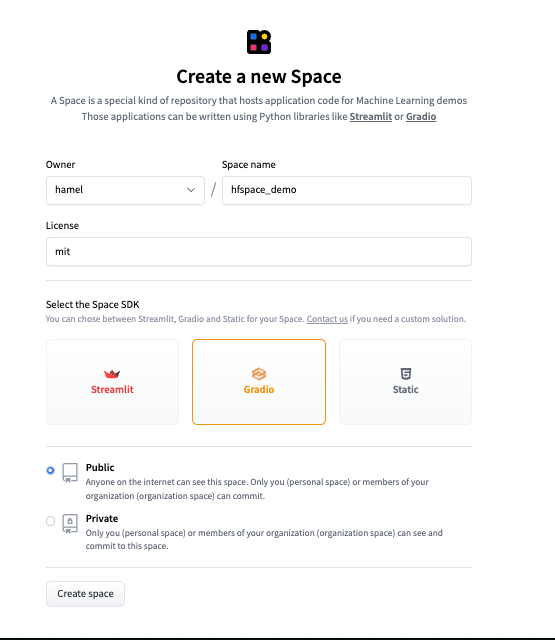

After you are done creating the space, clone the repo locally.  In this example, I ran the command `git clone https://huggingface.co/spaces/hamel/hfspace_demo`.


## 2. Create A Notebook

To follow along, create a notebook called `app.ipynb` in the root of your newly cloned repo. Alternatively, a minimal version of this notebook can also be [found here](https://gist.github.com/hamelsmu/35be07d242f3f19063c3a3839127dc67).

## 3. Make an app with Gradio

Below, we will create a [gradio](https://gradio.app/) app in a notebook and show you how to deploy it to [Hugging Face Spaces](https://huggingface.co/docs/hub/spaces). 

First, lets specify the libraries we need, which in this case are `gradio` and `fastcore`:

In [ ]:
#|export
import gradio as gr
from fastcore.net import urljson, HTTPError

Next, write the functions your gradio app will use.  Because of [nbdev](https://nbdev.fast.ai/blog/posts/2022-07-28-nbdev2/), you can prototype and package your code all in one place.  **The special comment `#|export` marks which cells will be sent to a python script** (more on this later). Note that there are only three cells in this notebook with the `#|export` directive.

In [ ]:
#|export
def size(repo:str):
    "Returns the size in GB of a HuggingFace Dataset."
    url = f'https://huggingface.co/api/datasets/{repo}'
    try: resp = urljson(f'{url}/treesize/main')
    except HTTPError: return f'Did not find repo: {url}'
    gb = resp['size'] / 1e9
    return f'{gb:.2f} GB'

`size` takes as an input a [Hugging Face Dataset](https://huggingface.co/docs/datasets/index) repo and returns the total size in GB of the data.

For example, I can check the size of [tglcourse/CelebA-faces-cropped-128](https://huggingface.co/datasets/tglcourse/CelebA-faces-cropped-128) like so:

In [ ]:
size("tglcourse/CelebA-faces-cropped-128")

'5.49 GB'

You can construct a simple UI with the `gradio.interface` and then call the `launch` method of that interface to display a preview in a notebook.  This is a great way to test your app to see if it works

In [ ]:
#|export
iface = gr.Interface(fn=size, inputs=gr.Text(value="tglcourse/CelebA-faces-cropped-128"), outputs="text")
iface.launch(height=450, width=500)

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


(<gradio.routes.App>, 'http://127.0.0.1:7861/', None)

Note how running the `launch()` method in a notebook runs a webserver in the background.  Below, we call the `close()` method to close the webserver.

In [ ]:
# this is only necessary in a notebook
iface.close()

Closing server running on port: 7861



## 4. Convert This Notebook Into A Gradio App

In order to host this code on Hugging Face Spaces, you will export parts of this notebook to a script named `app.py`.  As a reminder, this is what the special `#|export` comment that you have seen in cells above do!  You can export code from this notebook like so:

In [ ]:
from nbdev.export import nb_export
nb_export('app.ipynb', lib_path='.', name='app')

### Understanding what is generated

Notice how the contents of app.py only contains the exported cells from this notebook:

In [ ]:
%pycat app.py

# AUTOGENERATED! DO NOT EDIT! File to edit: app.ipynb.

# %% auto 0
__all__ = ['iface', 'size']

# %% app.ipynb 6
import gradio as gr
from fastcore.net import urljson, HTTPError

# %% app.ipynb 8
def size(repo:str):
    "Returns the size in GB of a HuggingFace Dataset."
    url = f'https://huggingface.co/api/datasets/{repo}'
    try: resp = urljson(f'{url}/treesize/main')
    except HTTPError: return f'Did not find repo: {url}'
    gb = resp['size'] / 1e9
    return f'{gb:.2f} GB'

# %% app.ipynb 12
iface = gr.Interface(fn=size, inputs=gr.Text(value="tglcourse/CelebA-faces-cropped-128"), outputs="text")
iface.launch(height=450, width=500)


### Fill out `requirements.txt`

You must supply a requirements.txt file so the Gradio app knows how to build your dependencies.  In this example, the only dependency other than Gradio is `fastcore`.  You don't need to specify Gradio itself as a dependency in `requirements.txt`, so our `requirements.txt` file has only one dependency:

In [ ]:
%%writefile requirements.txt
fastcore

Writing requirements.txt


_Note: you may want to add operating system dependencies in addition to python dependencies.  You can do this via a `packages.txt` file as [documented here](https://huggingface.co/docs/hub/spaces-dependencies#adding-your-own-dependencies)._

## 5. Launch Your Gradio App

To launch your gradio app, you need to commit the changes to the Hugging Face repo:

```
git add -A; git commit -m "Add application files"; git push
```

# Voilà!  Enjoy your Gradio App

After a couple of minutes, you will see your app published!  This app is published [here](https://huggingface.co/spaces/hamel/hfspace_demo).

# Shameless Plug: [nbdev](https://nbdev.fast.ai/blog/posts/2022-07-28-nbdev2/)

Hopefully you felt something magical while doing this example.  Even though the target application required you to write a python script (`app.py`), you didn't have to refactor your script from a notebook!  We believe that you shouldn't have to refactor your code and switch contexts even when creating python packages!  If this intrigues you, check out [nbdev](https://nbdev.fast.ai/blog/posts/2022-07-28-nbdev2/)